In [ ]:
import os
import random
import numpy as np
import json

from PIL import Image, ImageDraw, ImageFont
import cv2

def rotate(origin, point, angle):
    """Rotate point by an angle w.r.t. origin

    Args:
        origin : (x, y) coordinates of the origin
        point : (x, y) coordinates of the point to rotate
        angle : anti-clockwise angle in radians to rotate 

    Returns:
        rotated point: (x, y) coordinates of the rotated point
    """
    origin = np.array(origin)
    point = np.array(point)
    c, s = np.cos(angle), np.sin(angle)

    R = np.array([
      [c, s], 
      [-s,  c]
    ])
    O = origin + R @ (point - origin)
    return O.tolist()

def blend_images(background_image, text_image):
    array = np.array(text_image)
    white = (255, 255, 255)
    ycoords, xcoords = np.where((array == white).all(2))
    for x, y in zip(xcoords, ycoords):
        background_image.putpixel((x, y), white)

def generate_synthetic_dataset(
        output_directory: str="./dataset", 
        num_images: int=100,
        image_width=200, image_height=50,
        characters="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789", 
        angle_range=(-10, 10),
        font_size_range=(20, 30), 
        font_directory="./fonts",
        background_directory="./backgrounds", 
        num_characters=4, 
        num_words=4
    ):
    """Generate synthetic rotated OCR dataset at output_directory, by blending with images in background_directory

    Args:
        output_directory (str): path to store the generated dataset
        num_images (int): the number of images to generate
        image_width (int): output image width
        image_height (int): output image height
        characters (str): characters from which each word is sampled
        angle_range (tuple): angle (min, max) range 
        font_size_range (tuple): font size (min, max) range 
        font_directory (str): font directory containing .ttf 
        background_directory (str): background directory containing .jpg, .png, etc
        num_characters (int): the number of characters for each word (<= len(characters))
        num_words (int): the number of words to generate per image 
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Check if the font directory exists, otherwise use default font
    if os.path.exists(font_directory):
        fonts = [os.path.join(font_directory, font) for font in os.listdir(font_directory)]
    else:
        fonts = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')

    # Check if the background directory exists, otherwise use black background
    if os.path.exists(background_directory):
        backgrounds = [os.path.join(background_directory, bg) for bg in os.listdir(background_directory)]
    else:
        backgrounds = "black"

    # Anchor type to be used in PIL Image methods (lt = Coordinates relative to left top)
    # https://pillow.readthedocs.io/en/stable/handbook/text-anchors.html#text-anchors
    anchor_type = "lt"
    
    for i in range(num_images):
        # Randomly select a font and background
        font_size = random.randint(*font_size_range)
        random_font = random.choice(fonts) if isinstance(fonts, list) else fonts
        font = ImageFont.truetype(random_font, font_size)
        
        
        # Randomly pick from the backgrounds folder if any exists, else create black background
        background = Image.open(random.choice(backgrounds)) \
                          .convert("RGB") \
                          .resize((image_width, image_height)) if isinstance(backgrounds, list) \
                          else Image.new('RGB', (image_width, image_height), backgrounds) 
        
        all_bboxes = []
        all_texts = ""
        for j in range(num_words):
            
            # Generate black background for the text
            text_background = Image.new('RGB', (image_width, image_height), "black") 
            
            # Draw object from the choosen background
            draw = ImageDraw.Draw(text_background)

            # Generate a random string of characters
            text = ''.join(random.choices(characters, k=num_characters))

            # Calculate the width and height of the textbbox
            dims = draw.textbbox(xy=(0, 0), text=text, font=font, anchor=anchor_type)
            text_width, text_height = dims[2] - dims[0], dims[3] - dims[1]

            # Random left top coordinates of the text 
            random_x, random_y = random.randint(0, image_width-text_width), random.randint(0, image_height-text_height)
            x1, y1, _, _ = draw.textbbox(xy=(random_x, random_y), text=text, font=font, anchor=anchor_type)
            
            # Character wise textbboxes, which will be rotated w.r.t. the whole bbox center
            # Use ((x1, y1), (x1, y2), (x2, y1), (x2, y2)) representation for each vertex
            bboxes = []
            
            # x coord of the current character (y coord is the same)
            x_cursor = x1
            for ch in text:
                xmin, ymin, xmax, ymax = draw.textbbox(xy=(x_cursor, y1), text=ch, font=font, anchor=anchor_type)
                vertices = [[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]]
                bboxes.append(vertices)
                # move the cursor forward
                x_cursor += xmax-xmin
            
            # Center of the image to rotate each word's coordinates
            # Float coordinates used here to be precise 
            center_x, center_y = image_width / 2, image_height / 2

            # Draw the text on the background
            draw.text(xy=(x1, y1), text=text, font=font, fill=(255, 255, 255), anchor=anchor_type)

            # Rotate the image with text by a random angle
            # expand=False keeps the resolution same
            angle_deg = random.uniform(*angle_range)
            rotated_background = text_background.rotate(angle_deg, expand=False)

            # Paste text onto background (in-place)
            blend_images(background, rotated_background)
            # background = Image.blend(background, rotated_background, 0)

            # Convert the angle to radians
            angle_rad = np.radians(angle_deg)

            # Calculate the rotated coordinates
            for j in range(len(bboxes)):
                bboxes[j] = list(map(lambda xy: rotate(origin=(center_x, center_y), point=xy, angle=angle_rad), bboxes[j]))
            
            all_bboxes.extend(bboxes)
            all_texts = all_texts + text
            
        # Path to which the image is saved
        image_filename = f"{i:06d}.png"
        image_path = os.path.join(output_directory, image_filename)
        background.save(image_path)

        # Save the bounding box coordinates to a JSON file
        json_data = {
            "filename": image_filename,
            "bboxes": all_bboxes,
            "text": list(all_texts)
        }
        json_filename = f"{i:06d}.json"
        json_path = os.path.join(output_directory, json_filename)
        with open(json_path, 'w') as json_file:
            json.dump(json_data, json_file)


In [ ]:
generate_synthetic_dataset(output_directory="./synth_dataset", num_images=10, image_width=400, image_height=400,
                               characters="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789", angle_range=(-30, 30),
                               num_characters=4, font_size_range=(20, 30), font_directory="./assets/fonts",
                               background_directory="./assets/backgrounds", num_words=4)

In [ ]:
data_path = "./dataset"
import glob
images = sorted(glob.glob(f"{data_path}/*.png"))
labels = sorted(glob.glob(f"{data_path}/*.json"))

In [ ]:
idx = 3
image, label = images[idx], labels[idx]
ann = json.load(open(label, "r"))
image = Image.open(image)

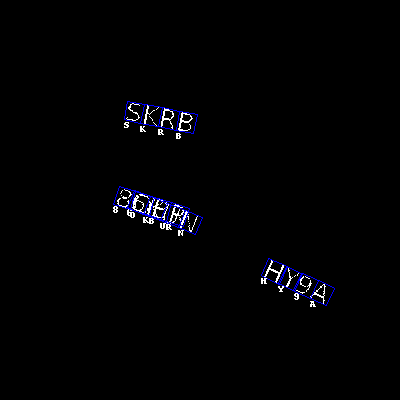

In [ ]:
from PIL import ImageDraw


draw = ImageDraw.Draw(image)
for bbox, label in zip(ann["bboxes"], ann["text"]):
    bbox = list(map(tuple, bbox))
    draw.polygon(bbox, outline=(0, 0, 255))
    draw.text(bbox[1], label, stroke_width=25)

image